In [1]:
%pylab inline
import pandas as pd

from mpl_toolkits.axes_grid.inset_locator import inset_axes

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

results = pd.read_csv('BC_final_results.csv', index_col=0)
ms_results = pd.read_csv('BC_MS_results.csv', index_col=0)
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
res.shape

(250, 12856)

In [3]:
sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values
Y = res[sres['g']].values.T

In [4]:
import GPy
import GPclust

In [28]:
np.random.seed(10)

m = GPclust.MOHGP(X=X,
                  Y=Y,
                  kernF=GPy.kern.RBF(2) + GPy.kern.Bias(2),
                  kernY=GPy.kern.RBF(1) + GPy.kern.White(1),
                  K=5,
                  prior_Z='DP')

m.hyperparam_opt_args['messages'] = False

m.optimize(step_length=0.1, verbose=False, maxiter=2000)

In [29]:
m

MOHGP.,value,constraints,priors
sum.rbf.variance,0.213993822484,+ve,
sum.rbf.lengthscale,0.948296294793,+ve,
sum.bias.variance,35.0723307463,+ve,
sum_1.rbf.variance,1.81096281843,+ve,
sum_1.rbf.lengthscale,82.5433657843,+ve,
sum_1.white.variance,0.465917600236,+ve,


In [30]:
m.phi_hat

array([ 43.01929421,  37.9842524 ,   5.        ,  18.99871388,   9.9977395 ])

In [31]:
sres['cluster'] = m.phi_.argmax(1)
Cs = m.predict_components(X)

K_hat = len(sres.cluster.unique())
K_hat

5

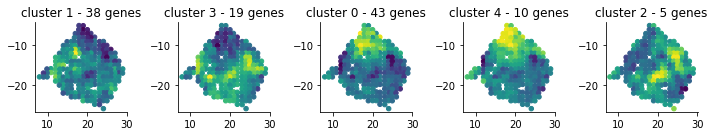

In [35]:
figsize(10, 2)
for i, Ci in enumerate(sres.cluster.unique()):
    C = Cs[0][Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('cluster {} - {} genes'.format(Ci, sres.query('cluster == @Ci').shape[0] ))
    
plt.tight_layout()

In [37]:
for i in sres.cluster.unique():
    
    print('Cluster {}'.format(i))
    print(', '.join(sres.query('cluster == @i')['g'].tolist()))
    print()

Cluster 1
ITGAX, KLHL15, ACTL8, HPS3, ETV7, SSPO, GHRH, SNAP25, C2orf40, ZNF280C, SLX4, IL21R, TYW5, WDR5B, PAQR8, ZNF880, GPIHBP1, IGLL5, PNMT, CXCL9, MMP10, CXCL13, IL12RB1, RPL28, STC2, SMYD1, SLC16A6, RPL41, CST3, RPL29, PEG10, PI15, SAA1, TFF1, EEF1A2, RPL13, RPL8, ITIH2

Cluster 3
HMGCS2, SPINT2, GPC3, HPN, SERPINA5, TFF3, BST2, FXYD3, DBI, COX6B1, LY6E, CST1, CTSD, WFDC2, CST4, PPP1R1B, AZGP1, BEX1, STARD10

Cluster 0
GJA1, C3, TGM2, FGG, MMP11, TMSB4X, BASP1, CILP, HTRA1, TNC, COL5A2, LOX, DCN, AEBP1, B2M, ANTXR1, SOD2, VCAN, HMCN1, MAFB, VIM, CTSK, CRISPLD2, SULF1, RARRES1, COL5A1, FGB, ASPN, CCDC80, GBP1, SPP1, ADAMTS2, THBS2, C1S, FCGR3A, HLA-DRA, PALLD, CTHRC1, COL11A1, LRRC15, PRRX1, MMP13, COL10A1

Cluster 4
COL6A3, POSTN, SPARC, COL12A1, COL3A1, COL1A1, SFRP2, LUM, COL1A2, FN1

Cluster 2
CLEC3A, PRSS23, IGFBP5, TP53INP2, AGT

